In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Path, PathPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from statistics import mean
import numpy as np
import scipy.interpolate
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import cartopy.mpl.geoaxes

In [8]:
conn = sqlite3.connect('GeoPVWattData.db')
c = conn.cursor()

Table creation code for column name reference

sql = """CREATE TABLE LatLonData(
         lat real,
         lon real,
         city text,
         state text,
         tilt real,
         azimuth real,
         azimuthname text,
         solrad_jan real,
         solrad_feb real,
         solrad_mar real,
         solrad_apr real,
         solrad_may real,
         solrad_jun real,
         solrad_jul real,
         solrad_aug real,
         solrad_sep real,
         solrad_oct real,
         solrad_nov real,
         solrad_dec real,
         solrad_average real,
       solrad_minus real,
         solrad_plus real,
         solrad_annual real,
         PRIMARY KEY (lat, lon, tilt, azimuth)
         )"""

In [9]:
# sql = """SELECT lat, lon, solrad_annual FROM LatLonData WHERE tilt = 0"""
sql = """SELECT lat, lon, solrad_annual FROM LatLonData WHERE tilt = 90 AND azimuth = 180"""
c.execute(sql)
# df=DataFrame(c.fetchall())
df = pd.read_sql(sql,conn)
print(df)

         lat      lon  solrad_annual
0     37.617 -122.400          3.344
1     40.783  -73.883          3.025
2     34.200 -118.350          3.518
3     41.783  -87.750          2.934
4     25.817  -80.300          2.870
...      ...      ...            ...
1533  51.930  -10.250          2.069
1534  52.730   15.230          1.692
1535  46.500   13.580          2.064
1536  54.230  -10.000          1.985
1537  41.630    0.600          3.554

[1538 rows x 3 columns]


C:\Users\Rachel\anaconda3\envs\cartopy\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


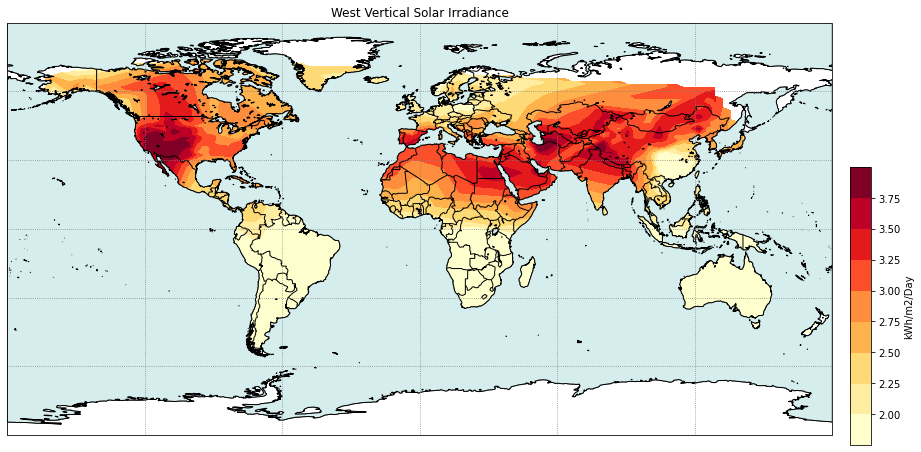

In [10]:
lons = df['lon'].tolist()
lats = df['lat'].tolist()
sol = df['solrad_annual'].tolist()


#setup grid of lat/lon values based on existing data
x, y = np.linspace(min(lons), max(lons), 100), np.linspace(min(lats), max(lats), 100)
x, y = np.meshgrid(x,y)
#interpolate solar radiation data over grid of lon/lat values
z = scipy.interpolate.griddata((lons, lats), sol, (x, y), method='linear')

#Create figure with desired earth projection and lat/lon framing desired
fig = plt.figure(figsize=[12,6])
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
usleft = -120
usright = -73
usbottom = 22
ustop = 50
# ax.set_extent([usleft, usright, usbottom, ustop], ccrs.Geodetic())
ax.set_global()

#Contour plot of solar radiation

# levels = [4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5.75]
levels = [2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75]
clrs = ([1,0.9294,0.6314],[0.9922,0.8549,0.4627],[0.9922,0.6980,0.2980],
        [0.9961,0.5529,0.2392],[0.9882,0.3059,0.1686],[0.8941,0.0980,0.1098],
        [0.7412,0,0.1490])
cplot=plt.contourf(x, y,z, levels,colors=clrs,transform=ccrs.PlateCarree(),extend='both')
cplot.cmap.set_under([1,1,0.8078])
cplot.cmap.set_over([0.5059,0,0.1490])

# Add a color bar
# plt.colorbar(ax=ax, shrink=.98)
cbar = fig.colorbar(cplot,ax=ax, fraction=0.025, pad = 0.02, aspect=10, anchor=(0,0), extend='both', 
             extendfrac='auto',extendrect=True)
cbar.set_ticklabels = levels
cbar.ax.set_ylabel('kWh/m2/Day')



# cbar.set_ticks([2,4.125,4.375,4.5,4.75,5,5.25])
# ticks = (np.arange(10) + 0.5)*(10-1)/10
# cbar.set_ticks(ticks)
# cbar.ax.get_yaxis().set_ticks([])
# for j, lab in enumerate([f'<{levels[0]}',levels[0],levels[1],levels[2],levels[3],levels[4],levels[5],
#                         levels[6],levels[7],f'>{levels[7]}']):
#     cbar.ax.text(.75, levels[0]-.5+(2 * j + 1) / 8.0, lab, ha='center', va='center')
# cbar.set_ticklabels([f'<{levels[0]}',levels[0],levels[1],levels[2],levels[3],levels[4],levels[5],
#                         levels[6],levels[7],f'>{levels[7]}'])

#     print(lab)

# title = 'Horizontal Solar Irradiance'
title = 'West Vertical Solar Irradiance'
ax.set_title(title)
ax.add_feature(cfeature.BORDERS)


        
#add coastlines, lat/lon lines, color ocean white
ax.coastlines('50m', linewidth=0.8)
ax.add_feature(NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='k', facecolor=(0.84 , 0.93, 0.93)))
ax.add_feature(NaturalEarthFeature('physical', 'lakes', '50m', edgecolor='k', facecolor=(0.84 , 0.93, 0.93)))

ax.gridlines(color=(0.5,0.5,0.5), linestyle="dotted")

plt.savefig(f'Images\\World_{title}.png',dpi=300,bbox_inches='tight')
plt.show()



In [25]:
conn.close()